In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 63.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

In [ ]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  0


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!ls "/content/drive/Shared drives/C242-PS290 Capstone Team Project"

 Brainstorming	'Cloud Computing'  'Machine Learning'  'Mobile Development'   Referensi


In [ ]:
# test_data_dir = '/content/drive/Shared drives/C242-PS290 Capstone Team Project/Machine Learning/Dataset_Tes/'
test_data_dir = '/content/drive/Shared drives/C242-PS290 Capstone Team Project/Machine Learning/Dataset_Preprocessing2_DaunTeh/test'

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6
EPOCHS = 100
VALIDATION_SPLIT = 0.2


# Test dataset (no split needed here)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


# Get the class names
class_names = test_dataset.class_names

Found 586 files belonging to 6 classes.


In [ ]:
# prompt: load the model

model_path = "/content/drive/Shared drives/C242-PS290 Capstone Team Project/Machine Learning/2024-12-08.h5"
model = tf.keras.models.load_model(model_path)

1/1 [==============================] - 2s 2s/step


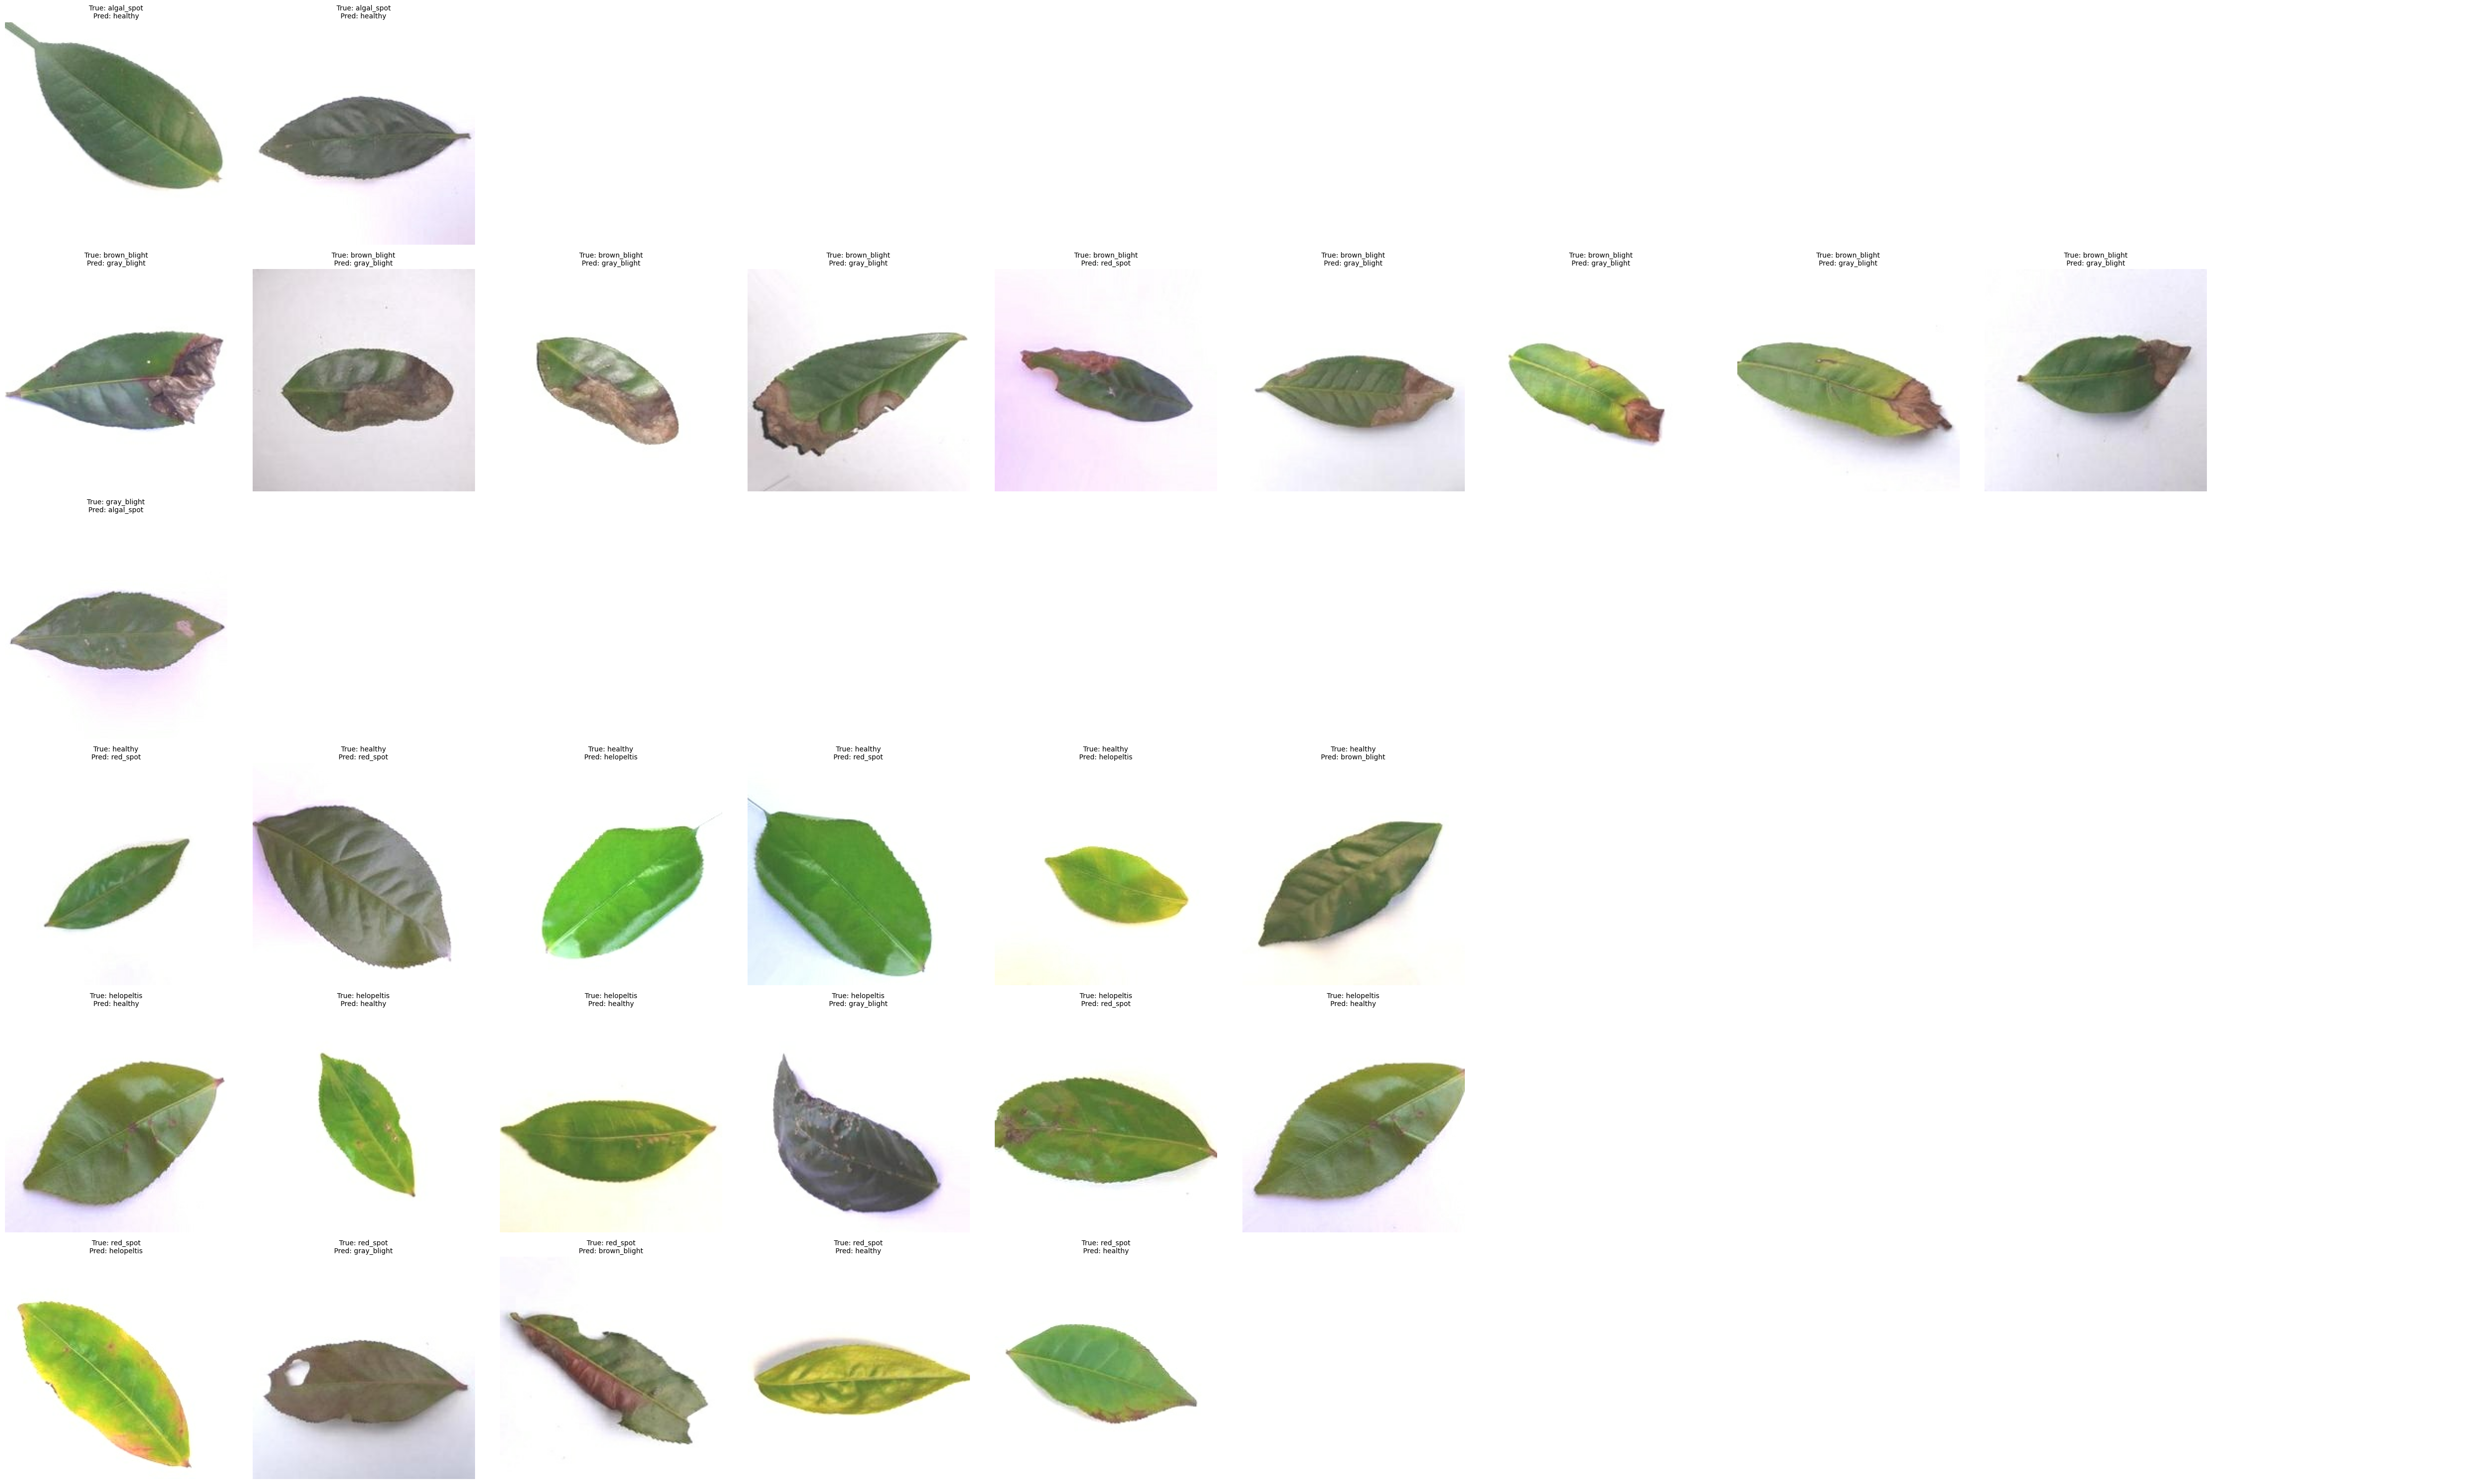

In [ ]:
# Mencerahkan gambar
def adjust_brightness(image, alpha=1, beta=50):
    # Gunakan convertScaleAbs untuk penyesuaian kecerahan
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Dictionary to store wrongly classified samples for each class
wrongly_classified = {class_name: [] for class_name in class_names}

# Assuming you have a trained model
for images, labels in test_dataset:
    # Apply brightness adjustment to each image before prediction
    # adjusted_images = np.array([adjust_brightness(image.numpy()) for image in images])
    adjusted_images = images

    predictions = model.predict(adjusted_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    # Identify wrongly classified samples and store them
    for i, (true_class, predicted_class) in enumerate(zip(true_classes, predicted_classes)):
        if true_class != predicted_class:
            true_class_name = class_names[true_class]
            wrongly_classified[true_class_name].append((adjusted_images[i], class_names[predicted_class]))

# Display the first few wrongly classified images for each class
num_samples_to_show = 10  # Number of images to display per class

fig, axes = plt.subplots(len(class_names), num_samples_to_show, figsize=(5*num_samples_to_show, 5 * len(class_names)))
if len(class_names) == 1:  # Handle the case where there's only one class
    axes = [axes]

for i, class_name in enumerate(class_names):
    wrong_samples = wrongly_classified[class_name]
    for j in range(num_samples_to_show):
        ax = axes[i][j] if len(class_names) > 1 else axes[j]
        if j < len(wrong_samples):
            image, predicted_label = wrong_samples[j]
            ax.imshow(image.numpy().astype("uint8"))
            ax.set_title(f"True: {class_name}\nPred: {predicted_label}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots

plt.tight_layout()
plt.show()


In [ ]:
# Initialize dictionaries to track total instances and false predictions for each class
total_instance = {class_name: 0 for class_name in class_names}
false_predictions = {class_name: 0 for class_name in class_names}

# Assuming you have a trained model
for images, labels in test_dataset:
    # Predict the class probabilities
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    # Update total instances and false predictions
    for true_class, predicted_class in zip(true_classes, predicted_classes):
        true_class_name = class_names[true_class]
        total_instance[true_class_name] += 1
        if true_class != predicted_class:
            false_predictions[true_class_name] += 1

# Print the frequency of false predictions for each class
print("Class-wise False Predictions:")
for class_name in class_names:
    total = total_instance[class_name]
    false = false_predictions[class_name]
    print(f"Class: {class_name}, False Predictions: {false}, Total Instances: {total}")


1/1 [==============================] - 2s 2s/step
Class-wise False Predictions:
Class: algal_spot, False Predictions: 2, Total Instances: 100
Class: brown_blight, False Predictions: 9, Total Instances: 86
Class: gray_blight, False Predictions: 1, Total Instances: 100
Class: healthy, False Predictions: 6, Total Instances: 100
Class: helopeltis, False Predictions: 6, Total Instances: 100
Class: red_spot, False Predictions: 5, Total Instances: 100
